In [1]:
import ee
import ee.deserializer
import geemap
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sisepuede.manager.sisepuede_examples as sxl

from generate import main
from pathlib import Path

In [2]:
data_path = Path(os.getenv("DATA_PATH"))
out_path = data_path / "generated"

In [3]:
ee.Initialize()

In [4]:
manager = sxl.SISEPUEDEExamples()

In [5]:
attr = manager.model_attributes.build_variable_dataframe_by_sector(
    None,
    include_model_variable = True,
    include_model_variable_attributes = True,
    include_simplex_group_as_trajgroup = False,
    include_time_periods = False,
)

In [64]:
df_in, df_out = main("BRA")

wanted_cols = [c for c in df_out.columns if c.startswith("emission_co2e_subsector_total")] + ["time_period"]
df_plot = (
    df_out
    [wanted_cols]
    .rename(columns={
        "emission_co2e_subsector_total_agrc": "Agricultura",
        "emission_co2e_subsector_total_frst": "Bosques",
        "emission_co2e_subsector_total_lndu": "Uso de suelo",
        "emission_co2e_subsector_total_lsmm": "Estiércol",
        "emission_co2e_subsector_total_lvst": "Ganado",
        "emission_co2e_subsector_total_soil": "Tierra",
    })
    .assign(time_period=lambda df: (df["time_period"] + 2000))
    .set_index("time_period")
    .drop(columns=["Tierra"])
)

df_total = df_plot.sum(axis=1)
df_total.index = df_total.index.astype(str)

In [65]:
df_area = pd.read_csv("./data/areas.csv").set_index("label").T.reset_index(names="year").assign(year=lambda df: (df["year"].astype(int) + 2000)).set_index("year")

(0.0, 521000.0)

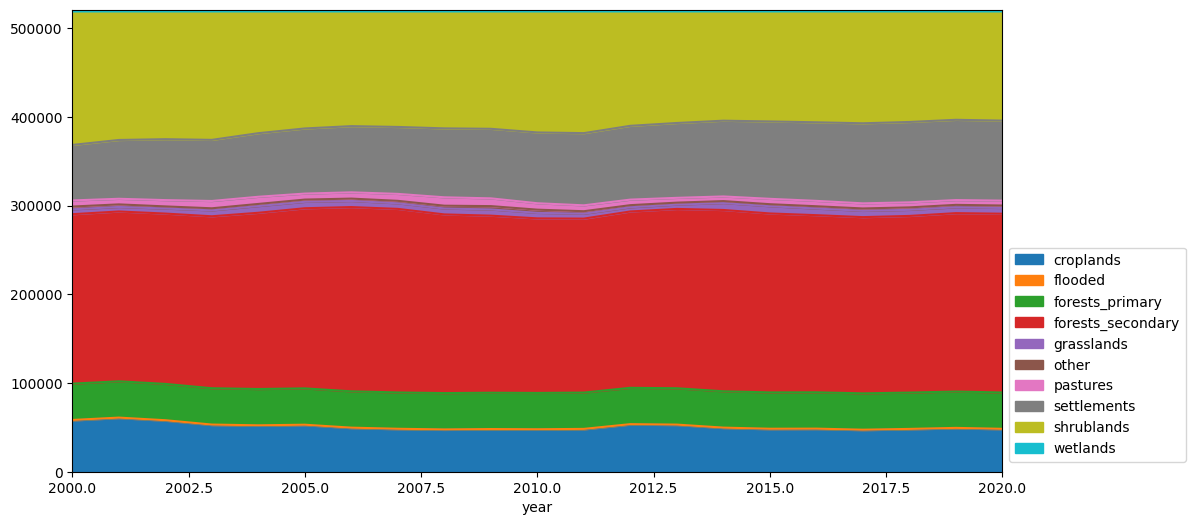

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))
df_area.plot.area(ax=ax)
ax.set_xlim(2000, 2020)
ax.legend(bbox_to_anchor=(1, 0.5))
ax.set_ylim(0, 521_000)

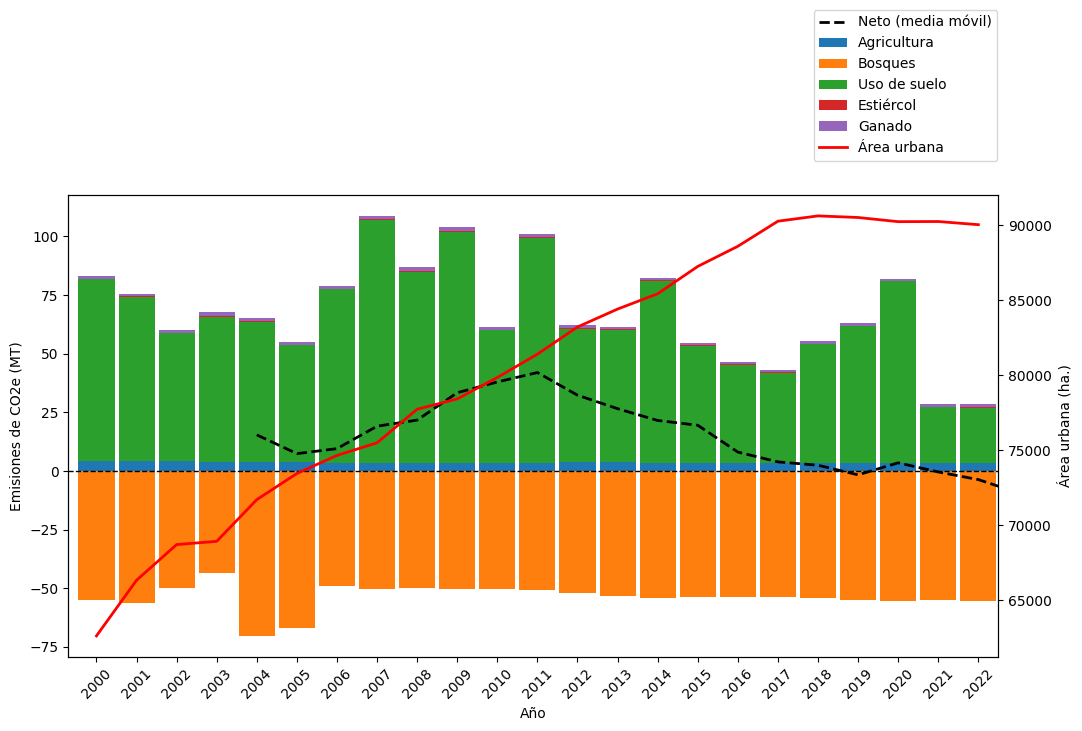

In [69]:
fig, ax = plt.subplots(figsize=(12, 6))
df_plot.plot.bar(stacked=True, width=0.9, ax=ax, legend=False)
# df_total.plot(ax=ax, color="black", linewidth=2, label="Neto")
df_total.rolling(5).mean().plot(ax=ax, color="black", linewidth=2, label="Neto (media móvil)", ls="--")
ax.axhline(0, color="black", linewidth=1, linestyle="--")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel("Año")
ax.set_ylabel("Emisiones de CO2e (MT)")

ax.set_xlim(-0.7, 22.5)

ax2 = ax.twinx()
temp = df_area.copy()
temp.index = temp.index.astype(str)
temp["settlements"].plot(ax=ax2, c="r", lw="2", label="Área urbana")
ax2.set_ylabel("Área urbana (ha.)")

fig.legend(bbox_to_anchor=(0.905, 1.2))
fig.savefig("./temp.jpg", bbox_inches="tight", dpi=200)

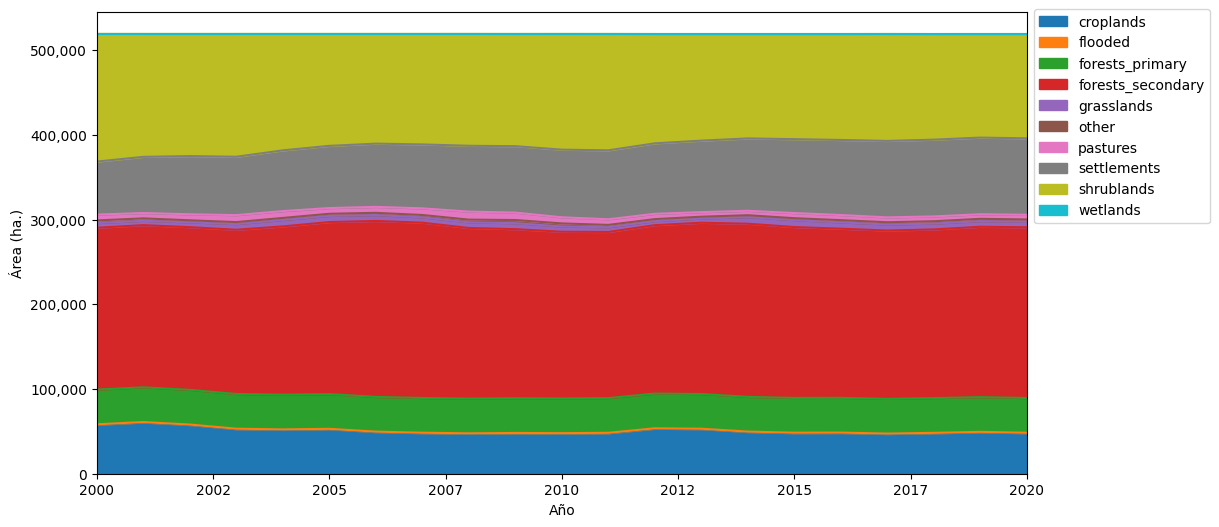

In [110]:
fig, ax = plt.subplots(figsize=(12, 6))
df_area.plot.area(stacked=True, ax=ax, legend=False)

ax.set_xlabel("Año")
ax.set_ylabel("Área (ha.)")

ax.set_xlim(2000, 2020)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: str(int(x))))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))

# ax2 = ax.twinx()
# df_plot.sum(axis=1).plot(ax=ax2, c="k", lw=2)

ax.legend(loc="upper left", bbox_to_anchor=(1, 1.02),)

fig.savefig("./temp.jpg", bbox_inches="tight", dpi=200)

# Transitions

In [70]:
with open(out_path / "transition_label_map.json") as f:
    label_map = json.load(f)
label_map = pd.DataFrame(label_map, index=["start", "end"]).T

In [78]:
with open(out_path / "small" / "transition" / "raster" / "2000_2001.json") as f:
    img = ee.deserializer.decode(json.load(f)).rename("2000_2001")

for year in range(2001, 2021):
    with open(out_path / "small" / "transition" / "raster" / f"{year}_{year + 1}.json") as f:
        temp_img = ee.deserializer.decode(json.load(f)).rename(f"{year}_{year + 1}")
        img = img.addBands(temp_img)

In [80]:
with open(out_path / "small" / "bbox" / "ee.json" ) as f:
    bbox_ee = ee.deserializer.decode(json.load(f))

In [83]:
geemap.download_ee_image(img, "./transitions.tif", region=bbox_ee, scale=30, crs="EPSG:4326")

transitions.tif: |          | 0.00/271M (raw) [  0.0%] in 00:00 (eta:     ?)

There is no STAC entry for: None


In [55]:
wanted_labels = label_map.query("end == 'forests_secondary'").index.values

mask = ee.image.Image.constant(0)
for label in wanted_labels:
    mask = mask.Or(transition_img.eq(int(label)))

m = geemap.Map()
m.addLayer(mask)
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
label_map

,start,end
0,croplands,croplands
1,croplands,flooded
2,croplands,forests_mangroves
3,croplands,forests_primary
4,croplands,forests_secondary
...,...,...
1006,wetlands,other
1007,wetlands,pastures
1008,wetlands,settlements
1009,wetlands,shrublands


In [53]:
label_map.query("end == 'forests_secondary'").index.values

array(['4', '104', '204', '304', '404', '504', '604', '704', '804', '904',
       '1004'], dtype=object)